In [15]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os

# IMU Signal Analysis: Nexar Model Performance Evaluation
##### Completed by Joshua Masri

In this analysis, we investigate the performance of a deployed machine learning classification model trained on Inertial Measurement Unit (IMU) data from Nexar dashcams. The model, built using pre-extracted accelerometer features, is designed to distinguish between **`normal`** driving events and **`collision`** events. This classification can enable early detection of critical driving incidents such as sudden stops or impacts.

We are provided with three datasets:
- `train.csv` and `test.csv`: contain pre-extracted features and labels used during model development.
- `inference.csv`: generated from raw signals in the field and used for real-time prediction (labels are provided separately in `inference_labels.csv`).

The main objective of this project is to **evaluate the generalization ability of the model** by comparing its performance on the inference data versus the original test data. Additionally, we aim to identify root causes for any performance degradation and propose both immediate and long-term improvements.

### Key Tasks
- Generate features from raw inference data.
- Run predictions using the provided trained model.
- Compare predicted vs actual labels on inference data.
- Analyze and compare performance against the test set.
- Conduct EDA to explore feature distributions and data drift.
- Suggest corrective actions and reflect on modeling assumptions.

### 1. Visualizing IMU Signals: Normal vs Collision Events

Before diving into model evaluation, it's important to understand the raw IMU signals that contain the model's features. In this section, we visualize examples of acceleration signals associated with `normal` and `collision` events.

By comparing these signal patterns, we can:
- Get a better feel for the input data structure and class separability.
- Identify whether certain events exhibit clear signal signatures.
- Develop intuition for which signal components (e.g., sudden spikes or directional changes) may influence model predictions.

Visual exploration also helps validate that the signal processing and labeling are aligned with physical expectations.

In [19]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

In [17]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

### Signal Inspection Summary: Normal vs Collision Events

#### Normal Driving
- **X and Y axes** show low, steady acceleration values near zero.
- **Z axis** remains consistently around ~9.8 m/s², likely capturing the effect of gravity.
- The signal is smooth and exhibits minimal variation across time, indicating stable motion.

#### Collision Event
- A distinct spike appears in the X and Y axes, around time ~65.
- The Z-axis stays stable, suggesting the collision was mostly horizontal.
- This sharp change in acceleration is the key differentiator and is expected to be a strong signal for classification.

#### Modeling Implications
- These spikes are likely captured by statistical features like max, std, skewness, and signal energy during feature extraction.
- Feature-based models (like the provided Random Forest) are expected to rely on these localized bursts of activity to distinguish collisions.
- If inference signals lack such distinct spikes, model reliability may degrade.

### 2. Generate Inference Features

To evaluate the model on new data, we first need to extract features from the raw IMU signal files in the `data/raw/inference/` directory.

Running `process_dataset('inference')` will generate a new file, `data/inference.csv`, containing the same statistical features as `train.csv` and `test.csv`, but **without any labels**. These features will serve as the input for the model's predictions in the next step.

In [42]:
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|████████████████████████████████████████| 473/473 [00:02<00:00, 219.84it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,2.578586,2.362892,8.999561,-5.200753,14.200314,0.193760,1.400440,31,1223.236383,2.995496,...,12,49,996,S603575,v1.3.0,ok,79,5.570705,4g,model_c
1,-0.114423,2.185548,10.289834,-5.283784,15.573618,2.164783,7.702143,5,478.971240,0.343485,...,22,75,607,S949312,v1.2.4,ok,81,3.181146,4g,model_c
2,0.061702,0.147340,0.291371,-0.208436,0.499806,-0.407912,-1.211002,15,2.551629,0.015451,...,30,52,482,S223545,v1.2.3,recent,95,2.987759,4g,model_b
3,1.354891,2.486652,11.114359,-6.365416,17.479775,0.764660,3.152818,15,801.916607,1.424555,...,11,36,463,S993755,v1.2.3,pending,47,9.744692,4g,model_a
4,0.061687,0.141320,0.278571,-0.246872,0.525443,-0.440889,-1.157643,17,2.377675,0.018567,...,13,41,759,S734746,v1.2.4,recent,37,3.622219,wifi,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.060402,0.141580,0.300225,-0.230982,0.531207,-0.394775,-1.216041,14,2.369336,0.015395,...,15,57,750,S165342,v1.2.4,ok,54,9.761510,4g,model_c
469,0.159769,2.509925,8.347333,-9.574540,17.921873,0.287556,3.356591,10,632.524802,1.805974,...,12,76,900,S653588,v1.3.0,pending,23,8.203065,4g,model_a
470,-0.548699,2.591718,6.550702,-8.426525,14.977227,-0.191147,1.450593,11,701.807315,1.414847,...,22,77,11,S945979,v1.3.0,pending,80,5.033353,5g,model_b
471,-0.559437,1.851954,4.829766,-6.744202,11.573968,-0.103196,1.832355,9,374.270158,1.994104,...,29,50,831,S424057,v1.3.0,pending,83,1.703700,5g,model_c


### 3. Load Ground Truth Labels for Inference

Although the `inference.csv` file contains extracted features, it does not include labels. To evaluate the model's predictions on the inference set, we load the true labels provided in `inference_labels.csv`, located in the `data/manual_annotation/` folder.

These labels serve as the ground truth for performance evaluation and allow us to calculate classification metrics such as accuracy, precision, recall, and F1 score.

In [21]:
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

### 4. Run Model Predictions

With the inference features prepared and the model loaded, we now generate predictions using the provided trained pipeline (`imu_pipeline.pkl`). This pipeline includes both preprocessing steps and a trained classifier.

We compute:
- `preds`: the predicted class labels (either "normal" or "collision").
- `probs`: the corresponding class probabilities, which can be useful for confidence analysis and threshold-based decisions.

These predictions will later be compared against the true labels from `inference_labels.csv` to assess model performance.

In [22]:
df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

### Initial Exploration of Test Dataset

Before diving into performance metrics or feature comparisons, we begin with a brief exploratory analysis of the `test.csv` dataset. This helps establish a baseline understanding of the feature space and class balance the model was originally evaluated on.

In this step, we:
- Load the test dataset
- Check for class distribution
- Review feature structure using `.info()` and `.describe()`

We assume the dataset is already cleaned (i.e., no missing values or duplicates).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x_mean               200 non-null    float64
 1   x_std                200 non-null    float64
 2   x_max                200 non-null    float64
 3   x_min                200 non-null    float64
 4   x_range              200 non-null    float64
 5   x_skew               200 non-null    float64
 6   x_kurtosis           200 non-null    float64
 7   x_n_peaks            200 non-null    int64  
 8   x_energy             200 non-null    float64
 9   y_mean               200 non-null    float64
 10  y_std                200 non-null    float64
 11  y_max                200 non-null    float64
 12  y_min                200 non-null    float64
 13  y_range              200 non-null    float64
 14  y_skew               200 non-null    float64
 15  y_kurtosis           200 non-null    flo

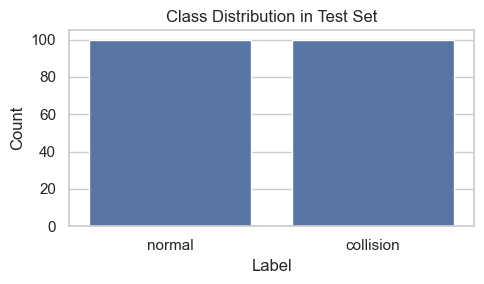

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load test data
test_df = pd.read_csv("data/test.csv")
test_df.head()

# Overview of structure
print(test_df.info())
print(test_df.describe())

# Class distribution
plt.figure(figsize=(5, 3))
sns.countplot(data=test_df, x='label')
plt.title("Class Distribution in Test Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Dataset Review: `test.csv`

#### Class Distribution
The dataset is perfectly balanced between the two target classes:
- `normal`: 100 samples
- `collision`: 100 samples

This makes `test.csv` a reliable reference for evaluating model performance under ideal class conditions.

#### Feature Overview
- Total rows: 200
- Total columns: 61
- Column types:
  - `float64`: 38 columns
  - `int64`: 8 columns
  - `object` (categorical/text): 15 columns

The dataset is clean and ready for modeling and EDA.

#### Key Observations from `.describe()`
- **X/Y-axis motion features** (e.g., `x_max`, `x_skew`, `x_energy`) show wide variation across samples and are likely important for detecting collisions.
- **Z-axis features** (e.g., `z_mean`) are stable around 9.8 m/s², consistent with gravitational acceleration. This metric is likely less informative for classification.
- **Engineered features** like `sudden_change_score`, `max_delta_mag`, and `fft_*` metrics may offer strong class separation.
- **Metadata features** (e.g., `driver_id`, `vehicle_type`, `firmware_version`, `weather`) should be investigated as they may introduce unwanted bias.

## 5. Evaluate and Compare

In this section, we assess how well the trained model performs on the `inference.csv` dataset compared to its performance on the original `test.csv` set. This includes:

- Computing classification metrics (accuracy, precision, recall, F1).
- Comparing these metrics between the inference and test sets.
- Performing exploratory data analysis (EDA) to understand potential differences in class distribution or feature behavior.
- Identifying and explaining any performance discrepancies, with the goal of proposing both short-term and long-term improvements.

This combined evaluation will help determine whether the model generalizes well to real-world data and where it might require refinement.

### 5.1 Evaluate Performance on Inference Set

We begin by evaluating the model’s predictions on the `inference.csv` dataset. This involves comparing the predicted labels against the true labels from `inference_labels.csv` using standard classification metrics.

We’ll compute:
- **Accuracy** – overall correctness of predictions
- **Precision** – how many predicted collisions were actually collisions
- **Recall** – how many actual collisions were successfully detected
- **F1 Score** – harmonic mean of precision and recall
- **Confusion Matrix** – detailed breakdown of true vs. predicted classes


Classification Report – Inference Set
              precision    recall  f1-score   support

   collision      0.516     0.839     0.639       236
      normal      0.573     0.215     0.313       237

    accuracy                          0.526       473
   macro avg      0.544     0.527     0.476       473
weighted avg      0.544     0.526     0.475       473



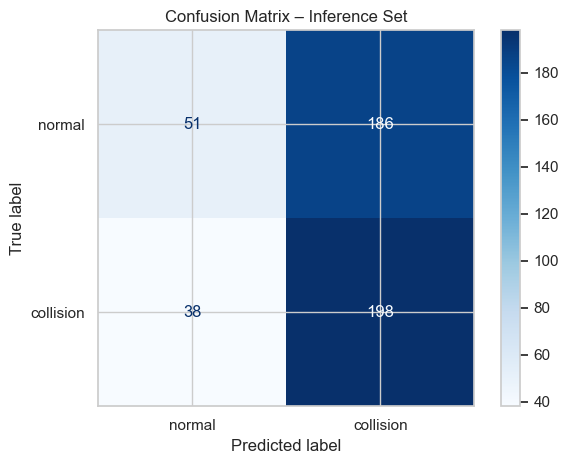

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# preds and probs already computed from the model
# labels should be loaded from inference_labels.csv


# Ensure alignment if needed
y_true = labels['label']
y_pred = preds  #preds generated from model.predict()

# Print classification metrics
print("Classification Report – Inference Set")
print(classification_report(y_true, y_pred, digits=3))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["normal", "collision"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "collision"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Inference Set")
plt.tight_layout()
plt.show()

### Inference Set Evaluation

The model's performance on the `inference.csv` dataset shows clear signs of degradation:

#### Overall Accuracy
- **52.6%**, which is barely above chance level for a binary classification problem.
- Indicates a drop in generalization ability compared to the expected performance.

#### Class-wise Performance

**Collision Events**
- **Precision:** 0.516 — around half of predicted collisions were correct.
- **Recall:** 0.839 — most actual collisions were successfully detected.
- **F1 Score:** 0.639 — moderate performance, driven by strong recall.

The model favors detecting collisions.

**Normal Events**
- **Precision:** 0.573 — just over half of predicted normal events were accurate.
- **Recall:** 0.215 — most actual normal events were misclassified.
- **F1 Score:** 0.313 — reflects poor recognition of normal driving patterns.

The model struggles significantly to detect normal events, leading to a high number of false positives.

#### Confusion Matrix Insight
- 186 normal samples were incorrectly labeled as collisions.
- Only 38 collisions were missed.

This suggests a **skewed decision boundary**, where the model leans heavily toward predicting the "collision" class.

#### Summary
- The model maintains **high sensitivity** to collisions, likely by design.
- However, **low specificity** (misclassifying normal events) could result in excessive false alarms.
- Potential reasons include:
  - Feature drift between test and inference sets
  - Training bias toward collision-heavy patterns
  - Shift in signal dynamics or sensor environment

### 5.2 Compare Against Test Set Performance

To understand whether the model's performance on the inference set truly reflects a generalization issue, we now compute the same classification metrics on the original `test.csv` dataset.

This set was used during model development and contains pre-extracted features with labels. By evaluating the model on this known data, we establish a performance baseline.

We will:
- Compute accuracy, precision, recall, F1 score
- Generate a confusion matrix for visual comparison
- Compare these results side-by-side with the inference set

Classification Report – Test Set
              precision    recall  f1-score   support

   collision      1.000     0.890     0.942       100
      normal      0.901     1.000     0.948       100

    accuracy                          0.945       200
   macro avg      0.950     0.945     0.945       200
weighted avg      0.950     0.945     0.945       200



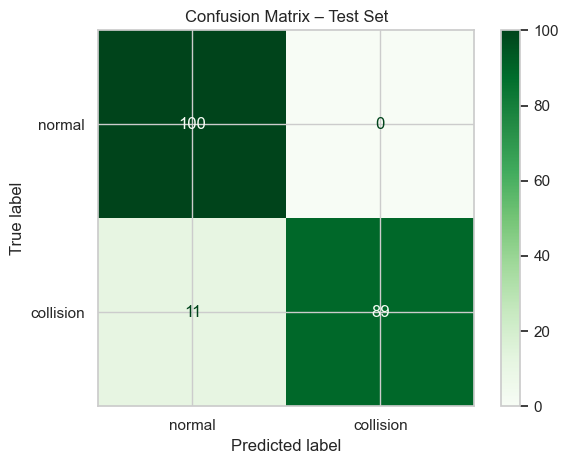

In [44]:
# Test set already loaded

# Separate features and labels
X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

# Predict using the same trained model
test_preds = model.predict(X_test)

# Print classification report
print("Classification Report – Test Set")
print(classification_report(y_test, test_preds, digits=3))

# Plot confusion matrix
cm_test = confusion_matrix(y_test, test_preds, labels=["normal", "collision"])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["normal", "collision"])
disp_test.plot(cmap='Greens')
plt.title("Confusion Matrix – Test Set")
plt.tight_layout()
plt.show()

### Test Set Evaluation

The model performs exceptionally well on the original `test.csv` dataset, achieving high scores across all standard classification metrics:

#### Overall Accuracy
- **94.5%**, indicating strong performance on data the model was likely evaluated on during development.

---

#### Class-wise Performance

**Collision Events**
- **Precision:** 1.000 — every predicted collision was correct.
- **Recall:** 0.890 — a small number of collisions (11) were missed.
- **F1 Score:** 0.942 — reflects balanced and confident collision detection.

**Normal Events**
- **Precision:** 0.901  
- **Recall:** 1.000 — no normal events were misclassified.
- **F1 Score:** 0.948 — the model shows perfect sensitivity to normal behavior in the test set.

This confirms that the model works very well on data that closely resembles its training distribution.

---

### Side-by-Side Comparison: Test Set vs Inference Set

| Metric             | Test Set | Inference Set |
|--------------------|----------|----------------|
| **Accuracy**       | 94.5%    | 52.6%          |
| **F1 – Normal**    | 0.948    | 0.313          |
| **F1 – Collision** | 0.942    | 0.639          |
| **Recall – Normal**| 1.000    | 0.215          |
| **Recall – Collision** | 0.890 | 0.839         |

---

### Summary
- The model performs with near perfection on the test set, confirming that it is capable of making accurate predictions when the data is consistent with the training distribution.
- On the inference set, performance degrades significantly, particularly for normal events, which are often misclassified as collisions.
- This confirms the presence of a **generalization gap** likely caused by distributional differences or unseen patterns in the field data.


### 5.3 Exploratory Data Analysis (EDA)

To better understand the performance gap between the test and inference datasets, we now turn to exploratory data analysis (EDA).

The goal of this section is to:
- Compare **class distributions** between test and inference sets
- Investigate **feature behavior** across datasets (e.g., value ranges, statistical shifts)
- Identify potential signs of **data drift**, **feature mismatch**, or **signal degradation**

By analyzing these structural differences, we aim to uncover the root causes behind the model's poor generalization to the inference data.

### 5.3.1 Class Distribution Comparison

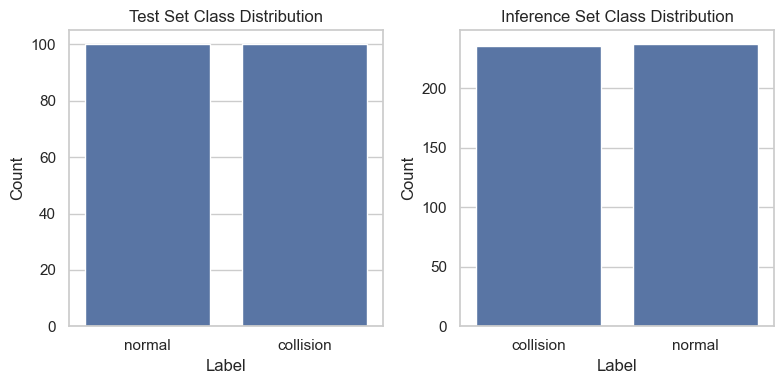

In [32]:
# Inference labels
inference_labels = labels

# Plot class counts side by side
plt.figure(figsize=(8, 4))

# Test set
plt.subplot(1, 2, 1)
sns.countplot(data=test_df, x="label")
plt.title("Test Set Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")

# Inference set
plt.subplot(1, 2, 2)
sns.countplot(data=inference_labels, x="label")
plt.title("Inference Set Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

We revisited class distributions to evaluate whether label imbalance could be contributing to the performance drop on the inference set. As previously observed during initial data checks, both datasets are well balanced:

| Dataset        | Normal | Collision |
|----------------|--------|-----------|
| Test Set       | 100    | 100       |
| Inference Set  | 237    | 236       |

This reinforces the conclusion that **class imbalance is not a factor** in the model's performance degradation. Therefore, the likely cause must lie in the distribution of feature values or signal characteristics, which we will investigate next.

### 5.3.2 Inspecting Failure Cases: False Negatives & False Positives

Visualizing raw signals for specific mis-classified samples helps reveal
whether muted spikes, excess noise, or other quirks mislead the model.

We’ll list a handful of `sample_id`s for:

* **False Negatives:** `true = collision`, `predicted = normal`  
* **False Positives:** `true = normal`, `predicted = collision`

Then we use `signal_viewer` widget to investigate signals visually.

In [49]:
# inference features + ground-truth labels
inf_features = df_inf                      
inf_labels   = labels

# ensure preds (model predictions) are aligned with inf_labels order
y_true = inf_labels["label"]
y_pred = preds                         # preds already computed earlier

# --- masks for failures ---
false_neg_mask = (y_true == "collision") & (y_pred == "normal")
false_pos_mask = (y_true == "normal")   & (y_pred == "collision")

false_neg_ids  = inf_labels.loc[false_neg_mask, "sample_id"]
false_pos_ids  = inf_labels.loc[false_pos_mask, "sample_id"]

print(f"False-negative collisions: {false_neg_ids.shape[0]}")
display(false_neg_ids.head(5))

print("\nFalse-positive normals:", false_pos_ids.shape[0])
display(false_pos_ids.head(5))

False-negative collisions: 38


2     3b0de448-dd4c-4300-949c-1d58b8f32795
4     284498b7-94bd-42fe-9e57-814554fab41f
6     0c898243-2688-47ed-babb-5001263ee6a3
8     561523f2-8644-4785-89d6-16158dc7ffb8
13    21897359-d6b8-4003-baab-9dffc88a2a5c
Name: sample_id, dtype: object


False-positive normals: 186


236    0db6ef85-819b-4ee5-9f5d-af83d42410b6
238    9d493a3f-bd54-4c5d-af95-ad1ac4d789d7
239    800ec379-dbef-4735-b33d-504730ac3897
240    613c3f78-5722-47eb-8349-6cf7ecaf6365
243    7d507ff3-4816-4472-a28a-9bd9aa8b7080
Name: sample_id, dtype: object

In [53]:
signal_viewer(
    data_dir=Path('data/raw/inference/'),
    labels_csv=Path('data/manual_annotation/inference_labels.csv')
)

In [54]:
signal_viewer(
    data_dir=Path('data/raw/inference/'),
    labels_csv=Path('data/manual_annotation/inference_labels.csv')
)

### Signal Snapshots of Mis-classified Samples Interpretation

Below are two raw-signal windows that illustrate how feature drift translates into real-world misclassifications.

| Example | True Label | Model Prediction | Key Visual Cues |
|---------|------------|------------------|-----------------|
| **A** | `collision` | `normal` *(false-negative)* | • Several sharp X/Y spikes yet the entire 100-frame window is highly erratic.<br>• Z-axis sits well above 9.8, hinting at sensor tilt or vertical vibration.<br>• Because noise is elevated throughout, aggregate statistics (e.g., `x_max`, `sudden_change_score`) do not stand out enough, so the model dismisses the collision. |
| **B** | `normal` | `collision` *(false-positive)* | • Many medium peaks; none dominate, but motion never truly settles.<br>• `sudden_change_score` and `mag_std` remain elevated.<br>• This persistent variability resembles the broader dual-peak distributions seen in drifted features, nudging the sample over the collision threshold even though no single high-magnitude impact occurs. |

**Take-aways**

1. **Dilution effect** In Example A the genuine impacts are masked by sustained background noise, reducing impact-ratio features and leading to a miss.  
2. **Noise leads to confusion** In Example B moderate, continuous jitter raises variability metrics, making an otherwise normal segment resemble a collision.  
3. **Selective drift sensitivity** Not every inference-time segment is noisier than training data; however, those that exhibit broader peaks or sustained variation fall outside the model’s learned boundaries, driving most of the observed errors.

### 5.3.3 – Feature Distribution Drift

With class imbalance has been ruled out, we explore whether the **distribution of input features differs** between the test and inference datasets.

Even small shifts in the range, spread, or shape of feature values can impact model performance, especially for models trained on statistical and frequency features.

We plot the distributions of selected features across both datasets. These features were chosen not only for their relevance to motion patterns but also due to measurable separation across classes observed in the `test.csv` dataset (see `.describe()` results).

- `x_energy`: high variability and upper range values up to 12.1, likely tied to sudden impact acceleration.
- `x_max`: a wide peak range indicating potential for spike-based separability.
- `sudden_change_score`: reflects bursty motion patterns often associated with collisions.
- `mag_std`: captures total acceleration variability, relevant for differentiating stable vs unstable driving.
- `x_fft_mean`: represents frequency characteristics of motion, which may shift in different environments.

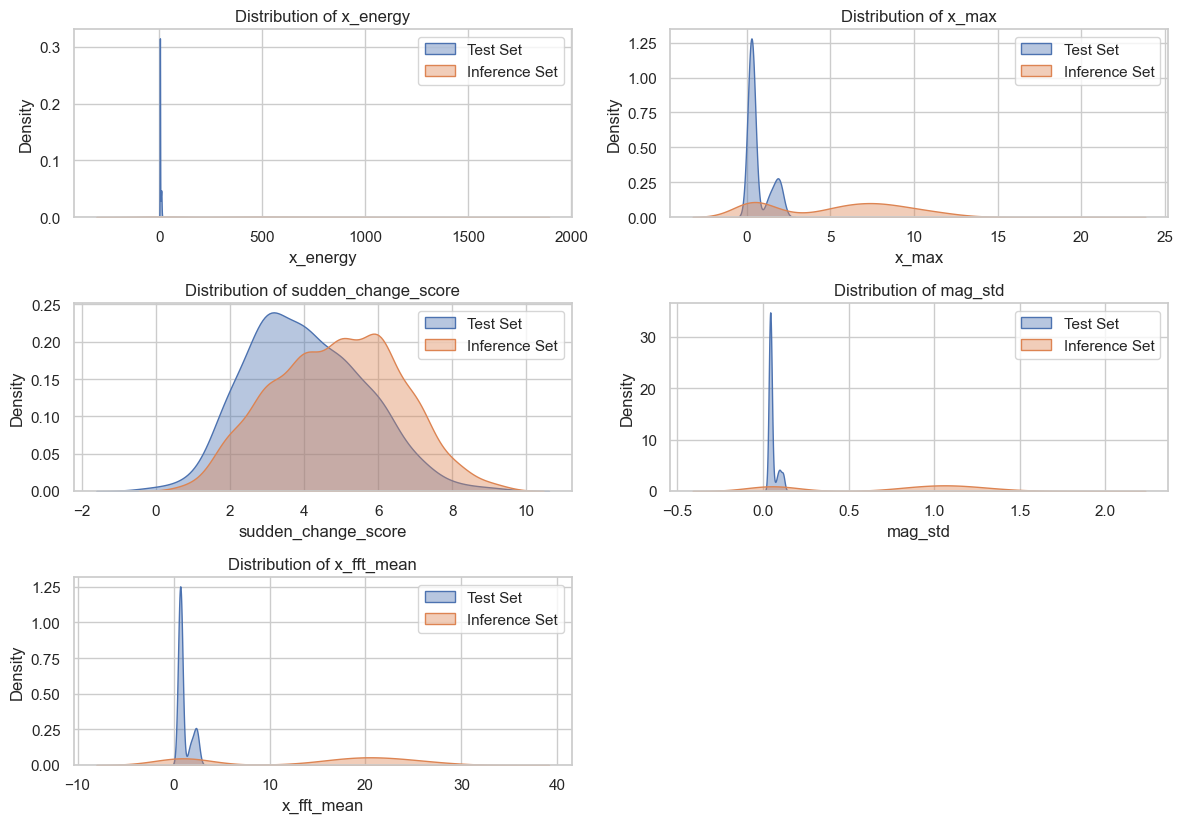

In [36]:
# List of features to compare
features_to_plot = [
    "x_energy",
    "x_max",
    "sudden_change_score",
    "mag_std",
    "x_fft_mean"
]

# Set up subplot grid
n_cols = 2
n_rows = (len(features_to_plot) + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.8 * n_rows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Create KDE plots
for i, feature in enumerate(features_to_plot):
    sns.kdeplot(data=test_df, x=feature, label="Test Set", fill=True, alpha=0.4, ax=axes[i])
    sns.kdeplot(data=inf_df, x=feature, label="Inference Set", fill=True, alpha=0.4, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Note on x_energy Visualization

The original KDE plot for `x_energy` was skewed due to extreme outliers in the inference set, which stretched the x-axis and obscured meaningful patterns.

To improve interpretability, we cropped values above 100 to focus on the primary distribution range, where the majority of samples lie.

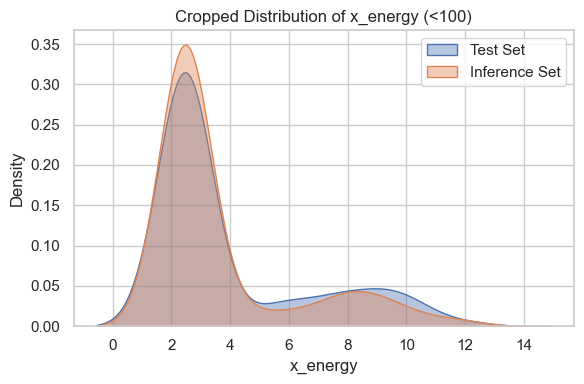

In [59]:
# Crop outliers for better visualization
def clip_feature(df, feature, max_val):
    return df[df[feature] < max_val]

# Apply cropping
test_clipped = clip_feature(test_df, "x_energy", 100)
inf_clipped = clip_feature(inf_df, "x_energy", 100)

# Plot cropped x_energy only
plt.figure(figsize=(6, 4))
sns.kdeplot(data=test_clipped, x="x_energy", label="Test Set", fill=True, alpha=0.4)
sns.kdeplot(data=inf_clipped, x="x_energy", label="Inference Set", fill=True, alpha=0.4)
plt.title("Cropped Distribution of x_energy (<100)")
plt.xlabel("x_energy")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

### Summary of Feature Distribution Drift

The following KDE plots compare the distributions of selected features between the `test.csv` and `inference.csv` datasets. These features were selected based on their statistical importance, observed variation in `.describe()` summaries, and relevance to motion dynamics.

The comparison reveals clear evidence of **feature distribution drift**, which likely contributes to the observed generalization failure when the model is evaluated on inference data.

---

#### `x_energy`
- The original plot was dominated by extreme outliers in the inference set, obscuring the true distribution.
- After cropping values above 100, we observe that the core distributions are quite similar in shape and peak location.
- The primary difference lies in the inference set’s **occasional high-energy outliers**, which could trigger false positives or unpredictable model behavior in rare cases.

---

#### `x_max`
- Both datasets show a **bimodal distribution**, but with different characteristics:
  - The test set is highly concentrated at low values, with a dominant peak near 0.5 and a weaker secondary peak.
  - The inference set shows a much broader spread, with two similarly sized peaks. This indicates a wider variety of acceleration events.
- This suggests inference-time motion is more dynamic or less filtered, which could disrupt a model trained on more constrained inputs.

---

#### `sudden_change_score`
- The inference set is shifted slightly rightward, with its peak closer to 5–6, compared to the test set's peak near 3–4.
- This may reflect more abrupt or frequent changes in acceleration patterns during inference.
- If the model heavily relies on this feature to detect collisions, the shift could lead to overprediction in noisy, high-change environments.

---

#### `mag_std`
- Both datasets again show a **bimodal distribution**, but with different emphasis:
  - The test set is tightly concentrated near 0, with one sharp dominant peak.
  - The inference set is more dispersed and exhibits two broader, less pronounced peaks, indicating greater signal variability.
- This difference suggests inference data contains a wider range of motion stability, possibly confusing the model.

---

#### `x_fft_mean`
- A similar pattern appears here: both sets are **bimodal**, but:
  - The test set has a strong peak near 0 and very little spread.
  - The inference set is more flattened and spread widely, with no clearly dominant frequency band.
- This implies that the temporal frequency behavior of the motion signal has changed in the field. This may violate assumptions the model learned during training.

---

### Interpretation

This analysis confirms that multiple key features exhibit **distributional shifts** between training/test and inference. These include:
- Increased spread
- Bimodal flattening
- Outlier emergence

Such shifts undermine the model’s assumptions about normal vs. collision behavior and likely explain why it struggles to correctly classify `normal` samples in the inference data.

These insights support the hypothesis that **data drift**, not class imbalance, is the dominant source of performance degradation.

## 5.3.4 Metadata Drift

To see whether contextual or hardware differences help explain the model’s inference-time errors, we compare the distribution of five metadata fields the model never explicitly used but may implicitly depend on:

| Feature | Justification |
|-------|----------------|
| `sensor_source` | Different sensors can introduce scaling or noise differences. |
| `device_model` | Hardware revision often affects sampling rate and sensitivity. |
| `firmware_version` | Firmware updates may alter signal filtering or calibration. |
| `road_type` | Surface conditions (highway vs. urban) change vibration patterns. |
| `speed_bin` | Vehicle speed influences overall acceleration magnitude. |

The table below shows each field’s top categories and their relative frequencies in **test** vs **inference** data.

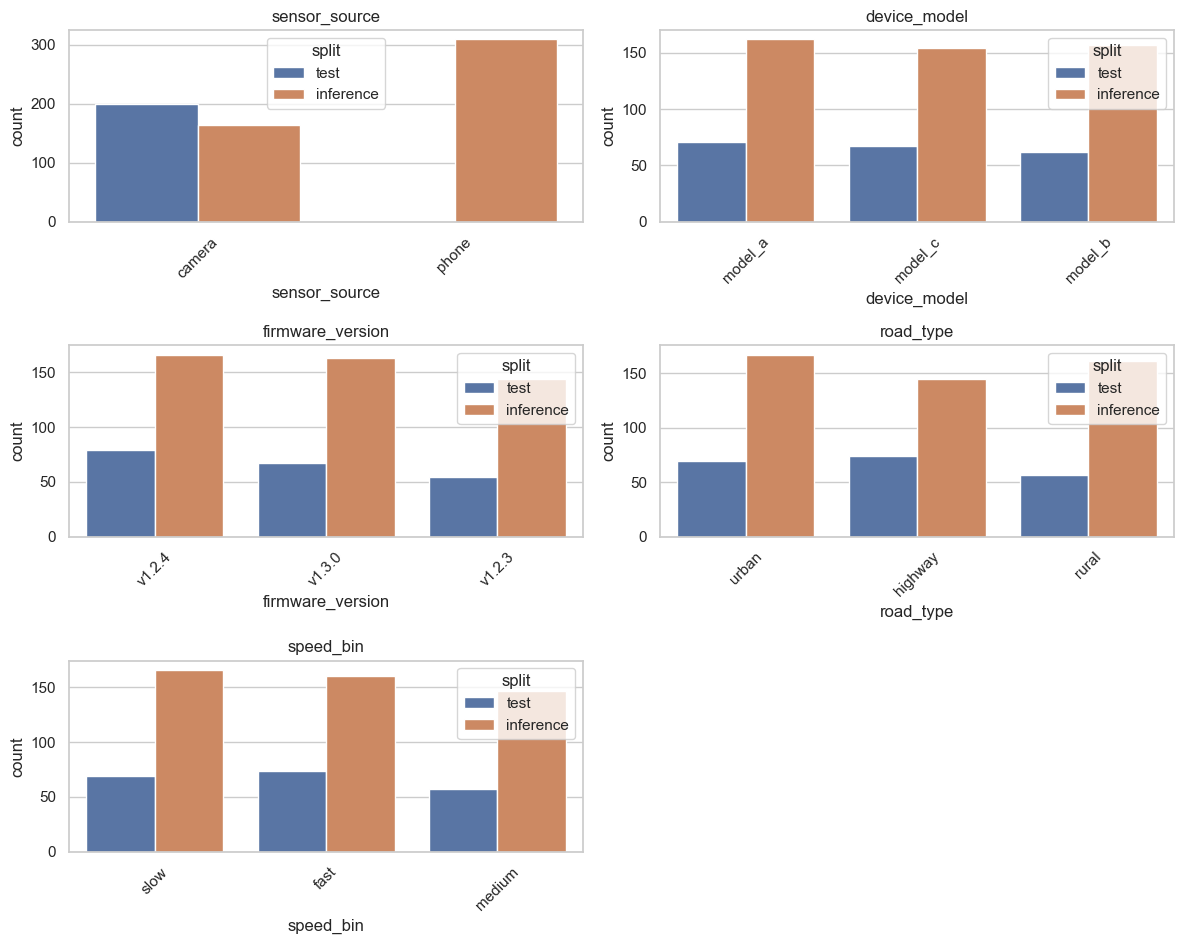

In [56]:
# Add a split label for grouping
test_df["split"] = "test"
inf_df["split"]  = "inference"

# Merge
df = pd.concat([test_df, inf_df], axis=0)

# Metadata fields to visualize
meta_cols = [
    "sensor_source",
    "device_model",
    "firmware_version",
    "road_type",
    "speed_bin"
]

# Set up subplots
n_cols = 2
n_rows = (len(meta_cols) + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.2 * n_rows))
axes = axes.flatten()

# Plot each metadata field
for i, col in enumerate(meta_cols):
    sns.countplot(
        data=df,
        x=col,
        hue="split",
        order=df[col].value_counts().index[:6],  # show top 6 categories
        ax=axes[i]
    )
    axes[i].set_title(f"{col}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplot if odd number
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Metadata Comparison Summary

#### Key Finding:  
Most metadata fields are **well-matched** between training and inference, suggesting the model was deployed in broadly familiar conditions.

#### Only notable difference: `sensor_source`
- The test set includes a higher proportion of camera-based data.
- The inference set has more samples labeled as phone-based sensors.

This difference could explain subtle shifts in motion signal characteristics, especially if phone sensors exhibit different sampling rates, mounting stability, or filtering behaviors compared to fixed cameras.

#### Other fields appear consistent:
- `device_model`, `firmware_version`, `road_type`, and `speed_bin` all show balanced representation across splits.
- No new categories appear exclusively in the inference data.

Next, we investigate whether inference-time false positives or false negatives correlate more strongly with the `sensor_source = phone` subset.

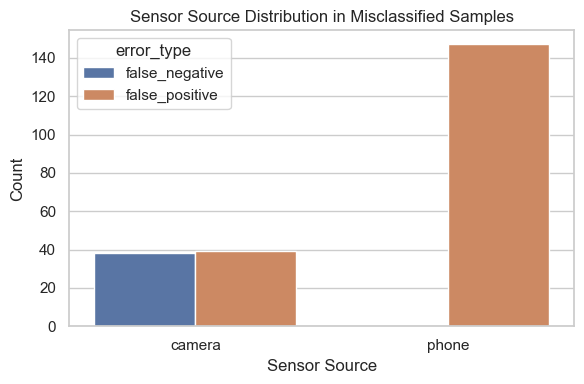

In [57]:
import pandas as pd

# Load required data
inference_df = pd.read_csv("data/inference.csv")                        
true_labels  = labels

# Make sure predictions (already run earlier) are available as `preds`
# true labels already aligned to sample_id
y_true = true_labels["label"]
y_pred = preds

# Add predictions and true labels back to metadata
inference_df = inference_df.copy()
inference_df["true_label"] = y_true
inference_df["predicted"]  = y_pred

# Define misclassifications
inference_df["error_type"] = "correct"
inference_df.loc[(y_true == "collision") & (y_pred == "normal"), "error_type"] = "false_negative"
inference_df.loc[(y_true == "normal") & (y_pred == "collision"), "error_type"] = "false_positive"

# Visualize sensor_source distribution across errors
plt.figure(figsize=(6, 4))
sns.countplot(
    data=inference_df[inference_df["error_type"] != "correct"],
    x="sensor_source",
    hue="error_type"
)
plt.title("Sensor Source Distribution in Misclassified Samples")
plt.ylabel("Count")
plt.xlabel("Sensor Source")
plt.tight_layout()
plt.show()

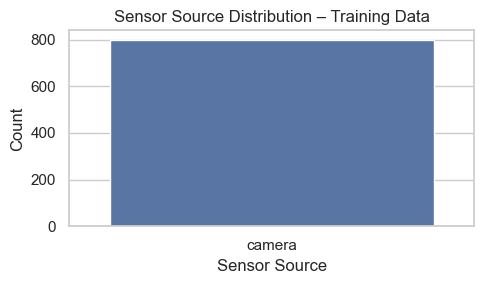

In [60]:
# Plot distribution of sensor_source in training data
plt.figure(figsize=(5, 3))
sns.countplot(data=train_df, x="sensor_source")
plt.title("Sensor Source Distribution – Training Data")
plt.ylabel("Count")
plt.xlabel("Sensor Source")
plt.tight_layout()
plt.show()

### Sensor Source & Misclassification Analysis

To better understand why the model overpredicts collisions in the inference set, we analyzed misclassified samples by `sensor_source` — distinguishing between data collected from **camera-mounted** sensors and **phone-based** sensors.

#### Key Observation:
- **Phone-based data is overwhelmingly responsible for false positives.**
  - Nearly all misclassified *normal* samples (false positives) originate from the `phone` sensor group.
  - In contrast, camera-based samples show a balanced and far smaller number of errors (both false positives and false negatives).

#### Interpretation:
- The model was trained **completely on camera-based** sensor data (see bar graph above).
- Phone sensors introduce signal variability (increased vibration, looser mounting, or different filtering characteristics) which alters downstream features like:
  - `x_max` (peak acceleration)
  - `mag_std` (motion variability)
  - `sudden_change_score` (spike frequency)
- These changes inflate motion features, causing normal phone data to resemble collisions.

#### Implication:
This suggests the model implicitly learned a collision threshold based on the calibration of camera sensors, and **misapplies it to phone-based data**, which drifts outside the expected feature space.

#### Recommendation:
- Apply **sensor-specific thresholding** or confidence filtering for phone-based predictions in the short term.
- In the longer term, **retrain or fine-tune** the model with a more representative mix of phone data to improve generalization.

## 3.5.5 Diagnose & Interpret

The model’s poor performance on the inference set is not caused by class imbalance, as both the test and inference datasets maintain a 50/50 split between `normal` and `collision` labels. Instead, detailed EDA reveals that the model struggles due to a combination of **feature distribution drift** and **sensor-related generalization failure**.

### 1. Feature Distribution Drift

A subset of key motion features (`x_max`, `mag_std`, `x_fft_mean`, and `sudden_change_score`) shift between test and inference sets:

- Several features show bimodal or flattened distributions in inference, indicating greater signal diversity or altered noise characteristics.
- Others exhibit higher spread or excess outliers, particularly in `x_energy`, suggesting rare but extreme events in the field.
- These drifts likely push many `normal` samples into the feature space learned for `collision`, increasing false positives.

### 2. Sensor Source Mismatch

Metadata analysis highlights a critical shift in hardware context:

- The test set is dominated by **`camera`-based sensors**, while the inference set is skewed heavily toward **`phone` sensors**.
- Visualizing misclassified samples reveals that false positives originate almost entirely from phone-based data.
- Phone sensors likely introduce increased jitter, looser mounting, or different sampling/filtering behaviors, which inflate motion-based features and confuse the model.

### 3. Signal-Level Investigation

Inspection of specific misclassified signals supports the above:

- False positives often show persistent low-to-mid jitter, inflating metrics like `mag_std` and `sudden_change_score`.
- Some false negatives contain genuine spikes, but they are diluted by overall noise, causing their impact to fall below model detection thresholds.

### Interpretation

The model was trained in a narrower feature space, primarily from camera-based sensors with more stable motion profiles. It **overfits to those conditions** and fails to generalize when deployed on more variable phone-based data.

These issues are systematic and explainable, pointing not to random error but to clear **domain drift** (in both the input feature space and the operational hardware environment).

## 3.5.6 Recommendations & Next Steps

To improve model robustness and address the specific failure modes uncovered in our analysis, we propose a tiered plan of action.

### Short-Term Mitigations

#### 1. Sensor-Aware Threshold Adjustment
- Apply stricter collision thresholds for `sensor_source = phone`, either via:
  - Separate feature scaling or
  - A post-prediction confidence filter (e.g., require a minimum `predict_proba > 0.7` for phone samples).
- This reduces overprediction without retraining.

#### 2. Flag Outlier Feature Profiles
- Flag anomalous feature patterns (e.g., extreme `x_energy`, overly high `mag_std`) as low-confidence predictions.
- These samples could be routed to human review or suppressed if downstream systems allow it.

#### 3. Monitor Inference Drift
- Add real-time drift monitoring on selected features (e.g., `x_max`, `sudden_change_score`).
- Alert when live distributions deviate significantly from training ranges, especially for newly introduced hardware.

### Medium-Term Actions

#### 1. Rebalance by Sensor Source
- Retrain or fine-tune the current model with a more **representative mix of camera and phone data**.
- Ensure phone-sourced data is sufficiently sampled in both training and validation sets.

#### 2. Feature Engineering to Normalize Sensor Noise
- Introduce sensor-specific feature transformations**, such as:
  - Z-score normalization per sensor batch
  - Removal of low-magnitude frequency components (to suppress jitter)
- This helps align motion profiles across device types.

#### 3. Augment with Synthetic Noise
- Inject controlled noise into clean training signals to improve generalization to real-world phone data.
  
### Long-Term Fixes

#### 1. Develop Sensor-Aware or Multi-Branch Models
- Train sensor-specific model heads or use metadata-aware architectures (e.g., add `sensor_source` as an input feature).
- This enables the model to adapt its decision boundary to the device type automatically.

#### 2. Shift from Handcrafted Features to Raw Signal Models
- Explore end-to-end architectures (e.g., CNNs or temporal transformers) on raw IMU windows.
- Raw models are often better at learning across sensor variation than handcrafted feature pipelines.

#### 3. Build a Feedback Loop
- Use post-deployment prediction feedback (e.g., false positives confirmed by users) to continually fine-tune the model on edge cases and emerging data conditions.

---

### Recommended Roadmap

| Timeframe     | Focus                         | Goal                                             |
|---------------|-------------------------------|--------------------------------------------------|
| **Now**       | Confidence thresholding + monitoring | Reduce critical false positives with low overhead |
| **Soon** | Retrain on rebalanced data     | Improve generalization to phone-sourced signals   |
| **Quarterly** | Engineer sensor-aware models   | Build resilience to hardware and context drift    |
| **6–12 mo**   | Shift to raw-signal modeling   | Unlock cross-device generalization and scale      |

---

By addressing the issue from multiple angles (operational, model-level, and architectural) we can reduce deployment risk, improve trust in predictions, and ensure long-term robustness as data and hardware evolve.

## 6. Reflection

### What do you observe when comparing the model’s predictions on the new data to its known performance?

The model performs well on the test set (accuracy ~94.5%) but drops to ~52.6% on the inference set. This isn't random noise: most errors in the inference set are false positives (normal driving events incorrectly labeled as collisions).

### Is there anything in the data that might explain differences in behavior?

Yes, analysis uncovered two primary sources of drift between training/test and inference data:

1. **Sensor Source Mismatch**  
   The test set is dominated by `camera`-based sensors, while inference data shifts heavily toward `phone` sensors. Phone sensors introduce more variability due to different mounting, sampling rates, and filtering. These differences affect downstream features.

2. **Feature Distribution Drift**  
   Several key features (`x_max`, `mag_std`, `x_fft_mean`, and `sudden_change_score`) shift significantly in inference. Their distributions are more dispersed, flattened, or outliar-heavy meaning the model sees signal behaviors it wasn’t trained on.

### Can you identify patterns or trends related to when the model succeeds or fails?

- The model succeeds on samples from `camera` sensors with clean, low-variance motion (similar to the domain it was trained on).
- It fails when inference signals have:
  - Elevated motion variability (high `mag_std`, `x_max`)
  - Broad or noisy frequency profiles
  - Features pushed out of training distributions
- Critically, false positives cluster almost entirely in the `phone` subset, pointing to a systemic generalization failure rather than isolated mistakes.
  
### Are there signals or features that seem to affect the model’s reliability?

Yes, these features appear influential:

- **Amplitude-Based**: `x_max`, `x_energy`, which are inflated during noisy motion and can mimic collision spikes.
- **Stability/Variability**: `mag_std`, `sudden_change_score`, which respond to irregular patterns.

Together, these features form the model’s decision backbone. These are susceptible to drift from sensor or context changes.

### What could be done in the short term to handle the current situation?

- Apply sensor-specific thresholds (e.g., require higher confidence for phone data).
- Flag high-risk predictions (e.g., abnormally high `x_energy`) for suppression or review.
- Add drift monitoring tools to detect statistically unusual distribution features in real-time.
- 
### What are potential long-term steps to improve model performance in similar scenarios?

- Retrain the model on a better-balanced dataset with adequate phone data.
- Engineer sensor-aware models that adapt their behavior depending on metadata (e.g., `sensor_source`, `device_model`).
- Move toward end-to-end learning from raw signals to reduce reliance on handcrafted features, which may not generalize well.

### What would you want to explore further if given more time or data?

- Collect more phone data across varied conditions (urban, highway, different drivers).
- Analyze device-specific behavior in more detail (are some phone models worse?).
- Investigate temporal modeling architectures that might better handle context.

### What assumptions did the model rely on during training — and are they still valid?

The model assumes:
- Signals come from camera-based sensors.
- Motion patterns are clean and class distributions are well-separated in feature space.

In deployment, these assumptions break down:
- New sensors introduce different feature distributions.
- Normal and collision classes overlap more in feature space due to jitter or varied motion.

As a result, the model learns with a limited training dataset, triggering systematic false positives. These assumptions are no longer fully valid, and retraining with a broader sensor/context distribution is necessary.